In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import urllib3

import tensorflow_datasets as tfds

In [3]:
Xception = tf.keras.applications.Xception(include_top=True, weights=None, input_shape=(224, 224, 3), classes=2)

In [4]:
# cats vs dogs 데이터셋
# https://east-rain.github.io/docs/Deep%20Learning/tensorflow%20tutorial/image_transfer_learning_preTrained.html

urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
    shuffle_files=True,
)

In [5]:
BATCH_SIZE = 32
EPOCH = 20

In [6]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [7]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [8]:
len_train = tf.constant(tf.data.experimental.cardinality(ds_train)).numpy()
len_test = tf.constant(tf.data.experimental.cardinality(ds_test)).numpy()

print(len_train)
print(len_test)

18610
4652


In [9]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, is_test=False, batch_size=BATCH_SIZE)

In [12]:
print(len_train)
print(len_test)

18610
4652


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./models/best_at_{epoch}.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

In [14]:
Xception.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_xception = Xception.fit(
    ds_train,
    steps_per_epoch=int(len_train/BATCH_SIZE),
    validation_steps=int(len_test/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[es, mc],
)

Epoch 1/20
581/581 [==============================] - 361s 579ms/step - loss: 0.7091 - accuracy: 0.6175 - val_loss: 0.5452 - val_accuracy: 0.7290

Epoch 00001: val_accuracy improved from -inf to 0.72900, saving model to ./models/best_at_1.h5
Epoch 2/20
581/581 [==============================] - 321s 553ms/step - loss: 0.3999 - accuracy: 0.8158 - val_loss: 0.4559 - val_accuracy: 0.8371

Epoch 00002: val_accuracy improved from 0.72900 to 0.83707, saving model to ./models/best_at_2.h5
Epoch 3/20
581/581 [==============================] - 321s 553ms/step - loss: 0.2494 - accuracy: 0.8936 - val_loss: 0.3483 - val_accuracy: 0.8706

Epoch 00003: val_accuracy improved from 0.83707 to 0.87056, saving model to ./models/best_at_3.h5
Epoch 4/20
581/581 [==============================] - 304s 524ms/step - loss: 0.1866 - accuracy: 0.9218 - val_loss: 0.3428 - val_accuracy: 0.8695

Epoch 00004: val_accuracy did not improve from 0.87056
Epoch 5/20
581/581 [==============================] - 290s 499ms/s

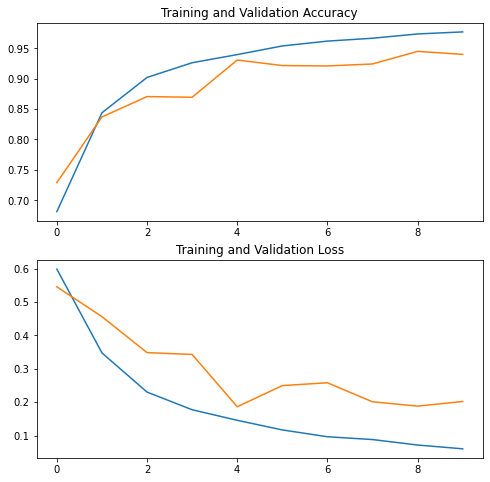

In [15]:
# history for acc and loss graph
acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']

loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()